In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


### Importing MIDI

music21 can be used to open, manipulate, play and save MIDI files.

In [3]:
from pathlib import Path
import music21 as m21

musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

final_fantasy_midi_path = Path('data/midi/Mana_GB_Final Fantasy Adventure_Battle 2.mid')
final_fantasy_midi = m21.midi.MidiFile()
final_fantasy_midi.open(final_fantasy_midi_path)
final_fantasy_midi.read()
final_fantasy_midi.close()

final_fantasy_midi

<music21.midi.MidiFile 2 tracks>

If we convert the MIDI file into a music21 stream we can play it back OK

In [4]:
final_fantasy_m21stream = m21.midi.translate.midiFileToStream(final_fantasy_midi)
final_fantasy_m21stream.show('midi')

We can get the bytes of a single track

In [5]:
final_fantasy_midi_trk_0 = final_fantasy_midi.tracks[0]
final_fantasy_midi_trk_0.getBytes()

b'MTrk\x00\x00\x00\xd5\x00\xffT\x05`\x00\x00\x00\x00\x00\xffX\x04\x04\x02\x18\x08\x00\xffY\x02\x02\x00\x00\xffQ\x03\x06\x1a\x80\x00\xffQ\x03\x06\x1a\x80\x00\xffQ\x03\x06\x1a\x80\xa0\x00\xffQ\x03\x06\x1a\x80\x81\xb0\x00\xffQ\x03\x06\x1a\x80\x82\x00\xffQ\x03\x06%\x92\x82\x00\xffQ\x03\x060*\x82\x00\xffQ\x03\x0652\x82\x00\xffQ\x03\x06@\x00\x82\x00\xffQ\x03\x06E\xc8\x82\x00\xffQ\x03\x06P\xd1\x82\x00\xffQ\x03\x06V\x11\x84\x00\xffQ\x03\x06\x1a\x80\x84\xfe\x00\xffQ\x03\x06\x1a\x80\x81\xb0\x00\xffQ\x03\x06\x1a\x80\x82\x00\xffQ\x03\x06%\x92\x82\x00\xffQ\x03\x060*\x82\x00\xffQ\x03\x0652\x82\x00\xffQ\x03\x06@\x00\x82\x00\xffQ\x03\x06E\xc8\x82\x00\xffQ\x03\x06P\xd1\x82\x00\xffQ\x03\x06V\x11\x84\x00\xffQ\x03\x06\x1a\x80\x84\xfd\x7f\xff/\x00'

However, if we try playing a single track stream it goes to shit because the timing info is in the parent track stream. I was a bit surprised as the merged track has all the tempo track info but ah well.

In [6]:
final_fantasy_m21stream_trk_0 = m21.midi.translate.midiTrackToStream(final_fantasy_midi_trk_0)
final_fantasy_m21stream_trk_0.show('midi')

It's looking like encoding the raw MIDI might be tricky, although something in my gut tells me it is the right way, or at least there is some insight to be had.

I think the best way forward is to pull in the basics from musicautobot and try to understand them. No point in running before we walk and all that.

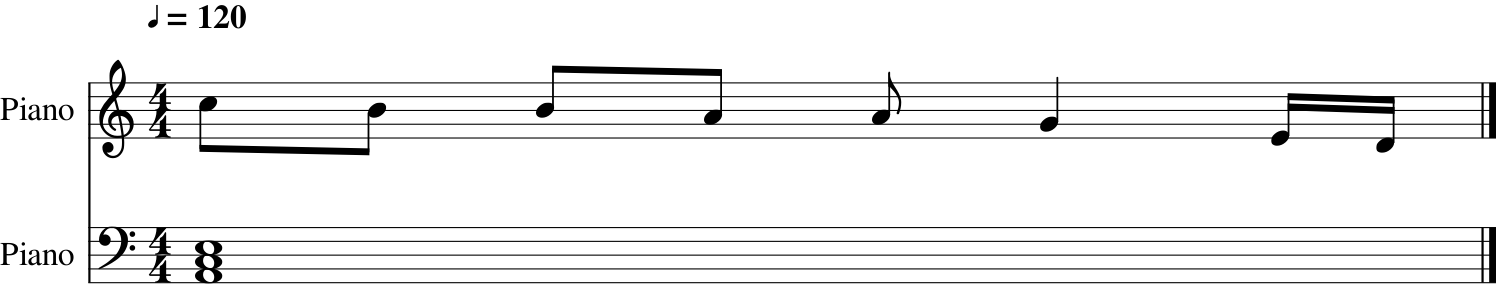

In [7]:
single_bar_path = Path('data/midi/single_bar_example.mid')

single_bar_midi_file = m21.midi.MidiFile()
single_bar_midi_file.open(single_bar_path)
single_bar_midi_file.read()
single_bar_midi_file.close()

single_bar_stream = m21.midi.translate.midiFileToStream(single_bar_midi_file)
single_bar_stream.show()

The offset in the left column is in 'quarter bars'

In [8]:
single_bar_stream.show('text')

{0.0} <music21.stream.Part 0x7f26096e4760>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C>
        {0.5} <music21.note.Note B>
        {1.0} <music21.note.Note B>
        {1.5} <music21.note.Note A>
        {2.0} <music21.note.Note A>
        {2.5} <music21.note.Note G>
        {3.5} <music21.note.Note E>
        {3.75} <music21.note.Note D>
        {4.0} <music21.bar.Barline type=final>
{0.0} <music21.stream.Part 0x7f26097d2200>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.BassClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord A2 C3 E3>
        {4.0} <music21.bar.Barline type=final>


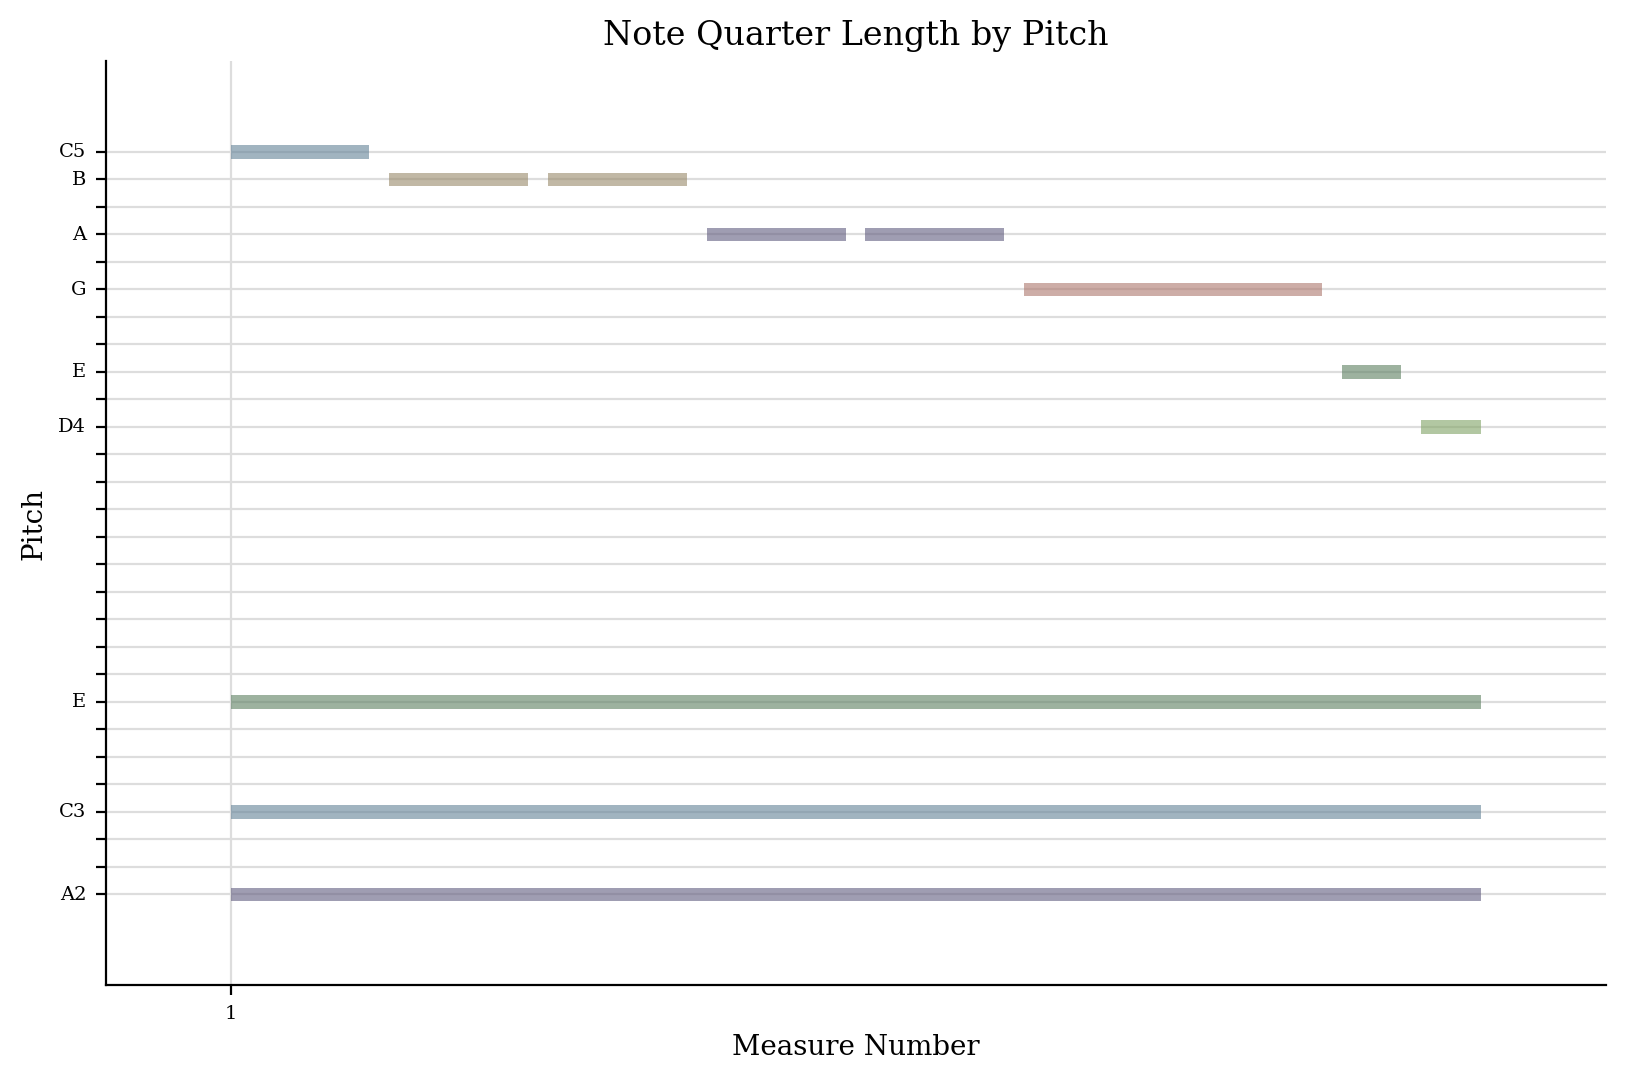

In [9]:
single_bar_stream.plot()

### Sparse Encoding

Code to convert a music21 stream into a sparsely encoded score adapted from musicautobot's `numpy_encode` module.

It is a tensor with a value for every timestep, instrument and pitch.

So, for e.g. with 4 beats at 4 divisions per bar = 16 timesteps per bar * 128 MIDI pitches = 2048 values per instrument, per bar.

In [10]:
import numpy as np
from itertools import chain

BEATS_PER_BAR = 4 # beats per bar
DIVISIONS_PER_QUARTER = 4 # i.e. 4 beats per bar and 4 divisions per beat gives 16 divisions per bar
MIDI_NOTE_COUNT = 128
MAX_NOTE_DUR = (8*BEATS_PER_BAR*DIVISIONS_PER_QUARTER)

def stream_to_sparse_enc(stream_score, note_size=MIDI_NOTE_COUNT, sample_freq=DIVISIONS_PER_QUARTER, max_note_dur=MAX_NOTE_DUR):    
    # Time is measured in quarter notes since the start of the piece
    # Original states that we are assuming 4/4 time but I don't see why that would be the case. BPB isn't used here.

    # (MusicAutobot author:) TODO: need to order by instruments most played and filter out percussion or include the channel
    highest_time = max(
        stream_score.flatten().getElementsByClass('Note').stream().highestTime,
        stream_score.flatten().getElementsByClass('Chord').stream().highestTime)
    
    # Calculate the maximum number of time steps
    max_timestep = round(highest_time * sample_freq) + 1
    sparse_score = np.zeros((max_timestep, len(stream_score.parts), note_size), dtype=np.int32)

    # Convert a note to a tuple of (pitch,offset,duration)
    def note_data(pitch, note):
        return (pitch.midi, int(round(note.offset*sample_freq)), int(round(note.duration.quarterLength*sample_freq)))

    for idx, part in enumerate(stream_score.parts):
        
        notes = chain.from_iterable(
            [note_data(elem.pitch, elem)] if isinstance(elem, m21.note.Note)
            else [note_data(p, elem) for p in elem.pitches] if isinstance(elem, m21.chord.Chord) 
            else []
            for elem in part.flatten()
        )

        # sort flattened note list by timestep (1), duration (2) so that hits are not overwritten and longer notes have priority
        notes_sorted = sorted(notes, key=lambda x: (x[1], x[2])) 

        for note in notes_sorted:
            if note is not None:
                pitch, timestep, duration = note
                clamped_duration = max_note_dur if max_note_dur is not None and duration > max_note_dur else duration
                sparse_score[timestep, idx, pitch] = clamped_duration
    
    return sparse_score

In [11]:
sparse_score = stream_to_sparse_enc(single_bar_stream); 
sparse_score.shape

(17, 2, 128)

`nonzero()` gives us the row and column indices of the non zero elements.

At timestep 1 (instrument * pitch), we can see that instrument (row) 0 has pitch (col) 72 active.

Instrument 1 has pitches 45, 48 and 52 active (A2 C3 E3).

In [12]:
timestep_1 = sparse_score[0].nonzero(); 
timestep_1

(array([0, 1, 1, 1]), array([72, 45, 48, 52]))

The value stored at the position indexed by `timestep*instrument*pitch` is the **length in beats** of that note.

For instance at timestep 0, on instrument 1, pitches 45, 48 and 52 begin to play for 16 beats:

In [13]:
sparse_score[0, 1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0, 16,  0,  0,
        0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

### Dense Encoding

Sparse encoding is too inefficient, so we want to just store what notes play and for how long.

Another function adapted from MusicAutobot:

In [14]:
from functools import reduce

SEPARATOR_IDX = -1 # separator value for numpy encoding
PIANO_RANGE = (21, 108)

# Pass in the 'one-hot' encoded numpy score
def sparse_to_position_enc(sparse_score, skip_last_rest=True):

    def encode_timestep(acc, timestep):
        encoded_timesteps, wait_count = acc
        encoded_timestep = timestep_to_position_enc(timestep) # pass in all notes for both instruments, merged list returned
        if len(encoded_timestep) == 0: # i.e. all zeroes at time step
            wait_count += 1
        else:
            if wait_count > 0:
                encoded_timesteps.append([SEPARATOR_IDX, wait_count])
            encoded_timesteps.extend(encoded_timestep)
            wait_count = 1
        return encoded_timesteps, wait_count
    
    encoded_timesteps, final_wait_count = reduce(encode_timestep, sparse_score, ([], 0))

    if final_wait_count > 0 and not skip_last_rest:
        encoded_timesteps.append([SEPARATOR_IDX, final_wait_count]) # add trailing rests

    return np.array(encoded_timesteps).reshape(-1, 2) # reshaping. Just in case result is empty
    
def timestep_to_position_enc(timestep, note_range=PIANO_RANGE):

    note_min, note_max = note_range

    def encode_note_data(note_data, active_note_idx):
        instrument, pitch = active_note_idx
        duration = timestep[instrument, pitch]
        if pitch >= note_min and pitch < note_max:
            note_data.append([pitch, duration, instrument])
        return note_data
    
    active_note_idxs = zip(*timestep.nonzero())
    encoded_notes = reduce(encode_note_data, active_note_idxs, [])
    sorted_notes = sorted(encoded_notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)

    # Dropping instrument information for simplicity.
    # MusicAutobot allows different encoding schemes which include instrument number and split pitch into class / octave.
    return [n[:2] for n in sorted_notes] 

This considerably reduces the size of the score.

In [15]:
position_score = sparse_to_position_enc(sparse_score)
position_score.shape

(18, 2)

In [16]:
f'Sparse encoding size: {np.prod(sparse_score.shape)}', f'Note encoding size: {np.prod(position_score.shape)}'

('Sparse encoding size: 4352', 'Note encoding size: 36')

Each row is a note on in the form of a pitch and a duration.

Notes can be 1-128, duration can be 1-256.

-1 is the rest / wait value

In [17]:
position_score

array([[72,  2],
       [52, 16],
       [48, 16],
       [45, 16],
       [-1,  2],
       [71,  2],
       [-1,  2],
       [71,  2],
       [-1,  2],
       [69,  2],
       [-1,  2],
       [69,  2],
       [-1,  2],
       [67,  4],
       [-1,  4],
       [64,  1],
       [-1,  1],
       [62,  1]])

### Vocab

Next we want to convert the raw note values into their vocab indexes, along with any special tokens we need to mark up our stream.

We also want to flatten into a 1D tensor e.g.

In [18]:
np.array([
        [1,2], 
        [3,4], 
        [5,6]]).reshape(-1)

array([1, 2, 3, 4, 5, 6])

We need an extended vocab of special tokens which represent important delimiters in our sequence.

This allows the model to understand how to start and finish sequences, plus gives it information about the breaks between notes and songs.

Notes and durations are our simplest 'data' tokens. They naturally have a number that we will append with `n` or `d` to form their text token.

The note sequence is appended to the special tokens, so its indices are equivalent to the note number offset by the number of special toekns.

Similarly, the duration indices are equivalent to their number offset by the count of special tokens + notes.

In [19]:
SOS = '<sos>' # Start of sequence
EOS = '<eos>' # End of sequence
SEP = '<sep>' # End of timestep (required for polyphony). Note index -1

 # SEP token must be last, i.e. one place before note tokens, so that adding the note offset still works when encoding
SPECIAL_TOKENS = [SOS, EOS, SEP]

MIDI_NOTE_COUNT = 128
NOTE_TOKENS = [f'n{i}' for i in range(MIDI_NOTE_COUNT)]

DURATION_SIZE = 8 * BEATS_PER_BAR * DIVISIONS_PER_QUARTER + 1 # 8 bars of sixteenth (semiquaver) notes + 1 for 0 length
DURATION_TOKENS = [f'd{i}' for i in range(DURATION_SIZE)]

NOTE_START, NOTE_END = NOTE_TOKENS[0], NOTE_TOKENS[-1]
DURATION_START, DURATION_END = DURATION_TOKENS[0], DURATION_TOKENS[-1]

ALL_TOKENS = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS

ALL_TOKENS[0:8]

['<sos>', '<eos>', '<sep>', 'n0', 'n1', 'n2', 'n3', 'n4']

In [20]:
from typing import Collection, List

class MusicVocab():
    def __init__(self):
        itos = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
        # Ensure that the vocab is a multiple of 8 for fp16 training
        if len(itos)%8 != 0:
            itos = itos + [f'dummy{i}' for i in range(len(itos)%8)]
        self.itos = itos
        self.stoi = {v:k for k,v in enumerate(self.itos)}

    def to_indices(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their indices."
        return [self.stoi[w] for w in t]

    def to_tokens(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of indices to their tokens."
        items = [self.itos[i] for i in nums]
        return sep.join(items) if sep is not None else items

    @property
    def bos_idx(self): return self.stoi[SOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def note_position_enc_range(self): return (self.stoi[SEP], self.stoi[DURATION_END]+1)
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def duration_range(self): return self.stoi[DURATION_START], self.stoi[DURATION_END]+1

### Converting to indices

Now that we have our indexed vocabulary, we can flatten our note / duration pairs into a single list, and map it into vocab indices (or text).

In [21]:
def position_to_idx_enc(note_position_score, vocab):
    note_idx_score = note_position_score.copy()
    note_min_idx, _ = vocab.note_range
    dur_min_idx, _ = vocab.duration_range
    
    # Replace note and duration tokens with their index in vocab. 
    # Tokens are the same order as notes and note_min_idx offset is constant so we can apply in one go.
    # Using broadcasting to add the 1D [note_min_idx, dur_min_idx] to the 2D note_idx_score.
    note_idx_score += np.array([note_min_idx, dur_min_idx])
    
    prefix =  np.array([vocab.bos_idx])
    suffix = np.array([vocab.eos_idx])

    return np.concatenate([prefix, note_idx_score.reshape(-1), suffix])

In [22]:
vocab = MusicVocab()
idx_score = position_to_idx_enc(position_score, vocab)
idx_score

array([  0,  75, 133,  55, 147,  51, 147,  48, 147,   2, 133,  74, 133,
         2, 133,  74, 133,   2, 133,  72, 133,   2, 133,  72, 133,   2,
       133,  70, 135,   2, 135,  67, 132,   2, 132,  65, 132,   1])

In [23]:
idx_score.shape

(38,)

In [24]:
vocab.to_tokens(idx_score)

'<sos> n72 d2 n52 d16 n48 d16 n45 d16 <sep> d2 n71 d2 <sep> d2 n71 d2 <sep> d2 n69 d2 <sep> d2 n69 d2 <sep> d2 n67 d4 <sep> d4 n64 d1 <sep> d1 n62 d1 <eos>'

### Decoding

Can we decode effectively?

We need to go idx -> note pos -> sparse -> stream

In [25]:
from itertools import groupby

TIMESIG = f'{BEATS_PER_BAR}/4'

# Combining notes with different durations into a single chord may overwrite conflicting durations.
def group_notes_by_duration(notes):
    get_note_quarter_length = lambda note: note.duration.quarterLength
    sorted_notes = sorted(notes, key=get_note_quarter_length)
    return [list(g) for k,g in groupby(sorted_notes, get_note_quarter_length)]

def sparse_instrument_to_stream_part(sparse_instrument_score, step_duration):
    part = m21.stream.Part()
    part.append(m21.instrument.Piano())
    
    for t_idx, pitch_values in enumerate(sparse_instrument_score):

        def decode_sparse_note(notes, pitch_index):
            note = m21.note.Note(pitch_index)
            quarters = sparse_instrument_score[t_idx, pitch_index]
            note.duration = m21.duration.Duration(float(quarters) * step_duration.quarterLength)
            notes.append(note)
            return notes
        
        pitch_idxs = np.nonzero(pitch_values)[0]

        if len(pitch_idxs) != 0: 
            notes = reduce(decode_sparse_note, pitch_idxs, [])
            for note_group in group_notes_by_duration(notes):
                note_position = t_idx*step_duration.quarterLength
                if len(note_group) == 1:
                    part.insert(note_position, note_group[0])
                else:
                    chord = m21.chord.Chord(note_group)
                    part.insert(note_position, chord)

    return part

def sparse_to_stream_enc(sparse_score, bpm=120):
    step_duration = m21.duration.Duration(1. / DIVISIONS_PER_QUARTER)
    stream = m21.stream.Score()
    stream.append(m21.meter.TimeSignature(TIMESIG))
    stream.append(m21.tempo.MetronomeMark(number=bpm))

    # Not required here but left as example of options available
    stream.append(m21.key.KeySignature(0))
    
    for inst in range(sparse_score.shape[1]):
        part = sparse_instrument_to_stream_part(sparse_score[:,inst,:], step_duration)
        stream.append(part)
    
    # Again, not required yet but left as example
    stream = stream.transpose(0)
    
    return stream

def position_to_sparse_enc(note_position_score):

    # Add all the separator durations as they denote the elapsed time
    score_length = sum(timestep[1] for timestep in note_position_score if timestep[0] == SEPARATOR_IDX) + 1
    
    # Single instrument as we discarded the instrument information when encoding
    # We will adapt to handle multiple instruments later
    instrument = 0

    def decode_note_position_step(acc, note_pos_step):
        timestep, sparse_score = acc
        note, duration = note_pos_step.tolist()
        if note < SEPARATOR_IDX:  # Skip special token
            return acc
        elif note == SEPARATOR_IDX:  # Time elapsed
            return (timestep + duration, sparse_score)
        else:
            sparse_score[timestep, instrument, note] = duration
            return (timestep, sparse_score)

     # (timesteps, instruments, pitches)
    initial_sparse_score = np.zeros((score_length, 1, MIDI_NOTE_COUNT))
    _, final_sparse_score = reduce(decode_note_position_step, note_position_score, (0, initial_sparse_score))

    return final_sparse_score

# No validation of note position encoding included to keep it simple for now
def idx_to_position_enc(idx_score, vocab):
    
    # Filter out special tokens
    notes_durs_start, notes_durs_end = vocab.note_position_enc_range # range of non-special token values
    notes_durations_idx_score = idx_score[np.where((idx_score >= notes_durs_start) & (idx_score < notes_durs_end))]

    # Reshape into pairs of (note, duration). If odd number of tokens, discard the last token.
    if notes_durations_idx_score.shape[0] % 2 != 0:
        notes_durations_idx_score = notes_durations_idx_score[:-1]

    position_score = notes_durations_idx_score.copy().reshape(-1, 2)
    
    # Shift token index values to note and duration values
    if position_score.shape[0] == 0: 
        return position_score
    else:
        note_min_idx, _ = vocab.note_range
        dur_min_idx, _ = vocab.duration_range
        position_score -= np.array([note_min_idx, dur_min_idx])
        return position_score

def idx_to_stream_enc(idx_score, vocab):
    position_score = idx_to_position_enc(idx_score, vocab)
    sparse_score = position_to_sparse_enc(position_score)
    return sparse_to_stream_enc(sparse_score)

Let's see if we can reconstruct the example from our encoding:

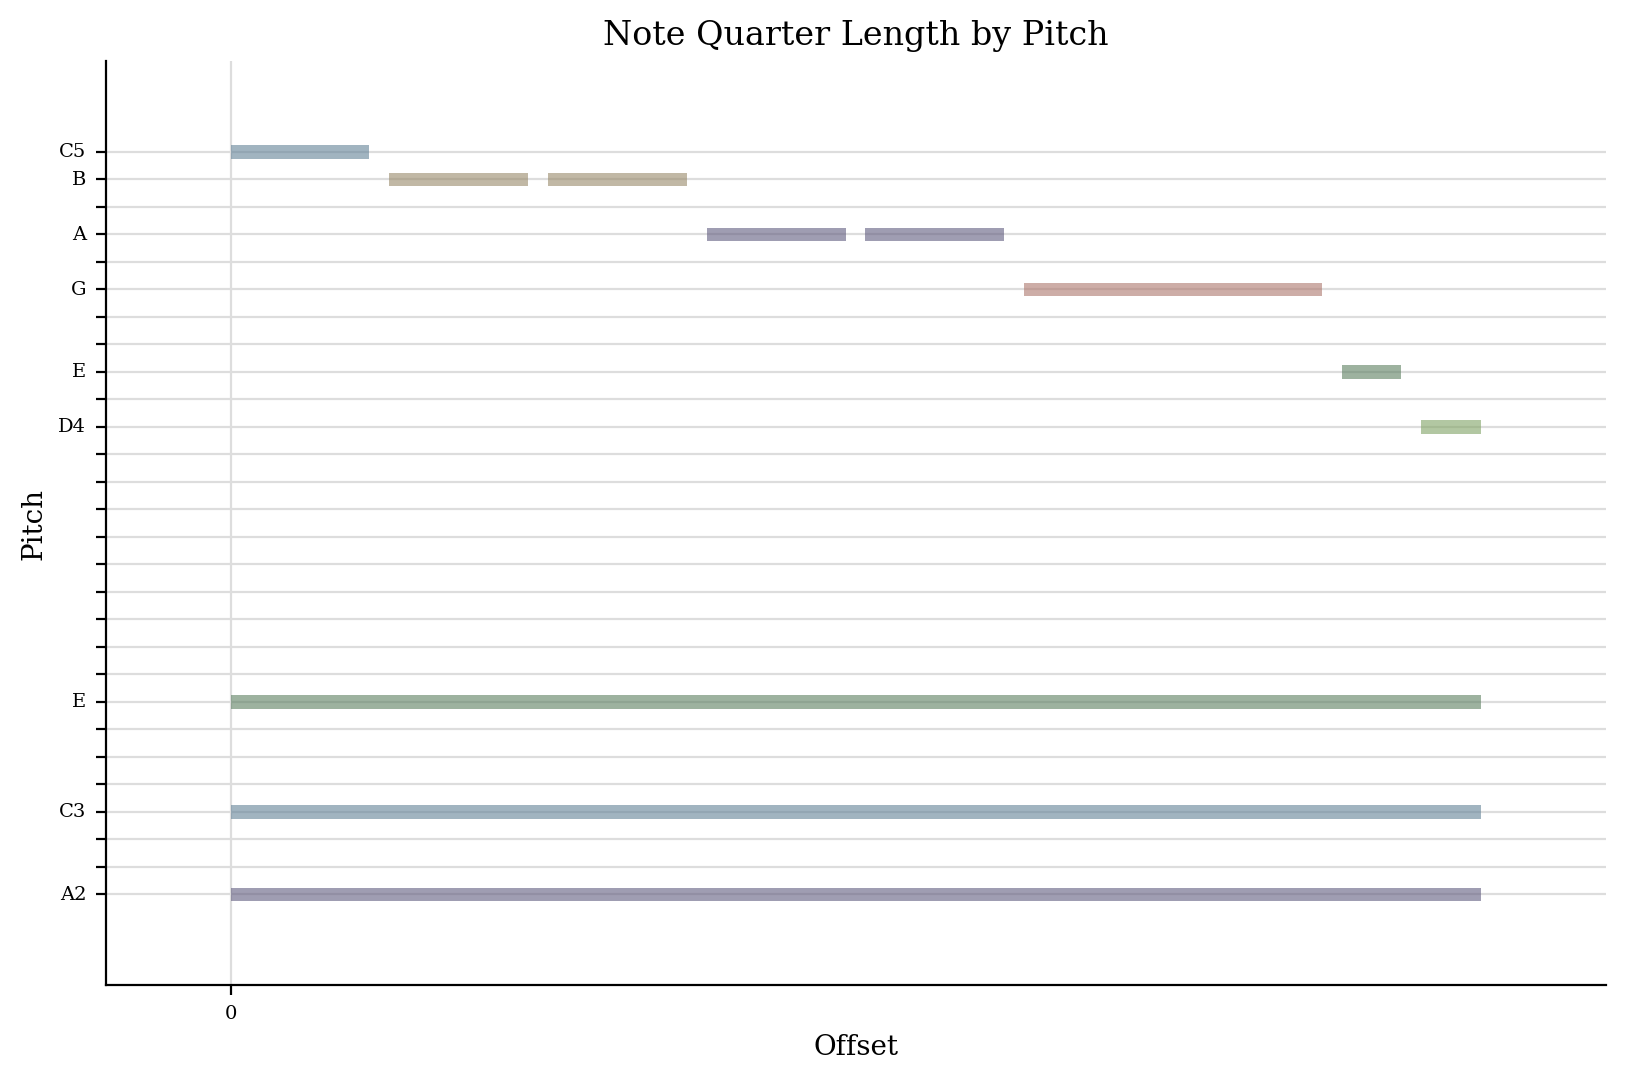

In [26]:
reconstructed_stream = idx_to_stream_enc(idx_score, vocab)
reconstructed_stream.plot()

In [27]:
single_bar_stream.show('midi')

In [28]:
reconstructed_stream.show('midi')

They sound the same and the MIDI plot looks pretty much identical. Lets look at the text representation:

In [29]:
reconstructed_stream.show('text')

{0.0} <music21.stream.Part 0x7f26082f3460>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.note.Note C>
    {0.0} <music21.chord.Chord A2 C3 E3>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note A>
    {2.5} <music21.note.Note G>
    {3.5} <music21.note.Note E>
    {3.75} <music21.note.Note D>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120>
{0.0} <music21.key.KeySignature of no sharps or flats>
{0.0} <music21.meter.TimeSignature 4/4>


In [30]:
single_bar_stream.show('text')

{0.0} <music21.stream.Part 0x7f26096e4760>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C>
        {0.5} <music21.note.Note B>
        {1.0} <music21.note.Note B>
        {1.5} <music21.note.Note A>
        {2.0} <music21.note.Note A>
        {2.5} <music21.note.Note G>
        {3.5} <music21.note.Note E>
        {3.75} <music21.note.Note D>
        {4.0} <music21.bar.Barline type=final>
{0.0} <music21.stream.Part 0x7f26097d2200>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.BassClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord A2 C3 E3>
        {4.0} <music21.bar.Barline type=final>


It is clear that we have lost some information - for example we didn't keep the instrument (i.e. Part) information, so we have a single flattened performance.

We also aren't considering velocity or any other CC signal.

Still, it's a good start and allows us to move forward.

#### Vocabulary considerations

As it stands this is essentially character-level encoding.

We haven't chunked tokens by training on example data. We simply have a single dedicated token for each note, duration and delimiter.

Perhaps we would have commonly lots of spaces, so separators would have chunked versions (e.g. '`<sep><sep>`', '`<sep><sep><sep>`' etc). That would save long silences using up all the context width (similar to how GPT grouping spaces to make source code easier to parse).

Also if we trained on enough data we would possibly find common riffs / melodies / progressions / rhythms etc that would form a richer, expressive vocabulary.

I can imagine blues licks chunking as they would show up a lot, and then being embedded in such a way that the model knows there is a blues vibe to the song.

If drum encoding is implemented, perhaps it would chunk a paradiddle?

In order to do that we need to load a lot of data (at least enough to train the tokeniser to find common motifs).

That's going to require parsing large numbers of files, dealing with bad data and odd structures, plus saving and loading the results.

Once we have loaded and processed the data into batches, we can try using a BPE (byte pair encoding) algorithm to chunk the tokens and see what it learns.

### Preparing data

First lets factor the MIDI file loading and converting functions out so we can reuse them.

In [31]:
def import_midi_file(file_path):
    midifile = m21.midi.MidiFile()
    if isinstance(file_path, bytes):
        midifile.readstr(file_path)
    else:
        midifile.open(file_path)
        midifile.read()
        midifile.close()
    return midifile

def midifile_to_stream(midifile): 
    return m21.midi.translate.midiFileToStream(midifile)

def midifile_to_idx_score(file_path, vocab):
    midifile = import_midi_file(file_path)
    stream = midifile_to_stream(midifile)
    sparse_score = stream_to_sparse_enc(stream)
    note_pos_score = sparse_to_position_enc(sparse_score)
    return position_to_idx_enc(note_pos_score, vocab)

Let's see if we can load and encode final fantasy in one step:

In [32]:
final_fantasy_idx_score = midifile_to_idx_score(final_fantasy_midi_path, vocab)
vocab.to_tokens(final_fantasy_idx_score)

'<sos> n62 d1 <sep> d1 n64 d1 n59 d1 <sep> d2 n61 d1 <sep> d1 n66 d1 <sep> d1 n67 d1 n62 d1 <sep> d2 n64 d1 <sep> d1 n66 d1 <sep> d1 n64 d1 n62 d1 <sep> d2 n61 d1 <sep> d1 n62 d1 <sep> d1 n66 d1 n59 d1 <sep> d1 n71 d1 n64 d1 <sep> d1 n73 d1 <sep> d1 n74 d8 n66 d2 n47 d2 <sep> d2 n67 d2 n59 d2 <sep> d2 n66 d2 n47 d2 <sep> d2 n64 d1 n59 d2 <sep> d1 n66 d3 <sep> d1 n47 d2 <sep> d2 n74 d2 n66 d2 n59 d2 <sep> d2 n76 d2 n67 d2 n47 d2 <sep> d2 n78 d2 n69 d2 n59 d2 <sep> d2 n78 d2 n69 d2 n45 d2 <sep> d2 n57 d2 <sep> d1 n76 d3 n67 d3 <sep> d1 n45 d2 <sep> d2 n74 d2 n66 d2 n57 d2 <sep> d2 n73 d6 n64 d2 n45 d2 <sep> d2 n61 d2 n57 d2 <sep> d2 n64 d2 n45 d2 <sep> d2 n73 d1 n71 d1 n69 d1 n67 d1 n57 d1 <sep> d2 n74 d8 n71 d2 n43 d2 <sep> d2 n69 d2 n55 d2 <sep> d2 n67 d2 n43 d2 <sep> d2 n69 d1 n55 d2 <sep> d1 n71 d5 <sep> d1 n43 d2 <sep> d2 n74 d2 n55 d2 <sep> d2 n76 d2 n73 d2 n43 d2 <sep> d2 n74 d2 n71 d2 n55 d2 <sep> d2 n73 d2 n69 d2 n42 d2 <sep> d2 n54 d2 <sep> d1 n71 d3 n66 d3 <sep> d1 n42 d2 <sep

And decoding?

In [33]:
final_fantasy_idx_score.shape

(3162,)

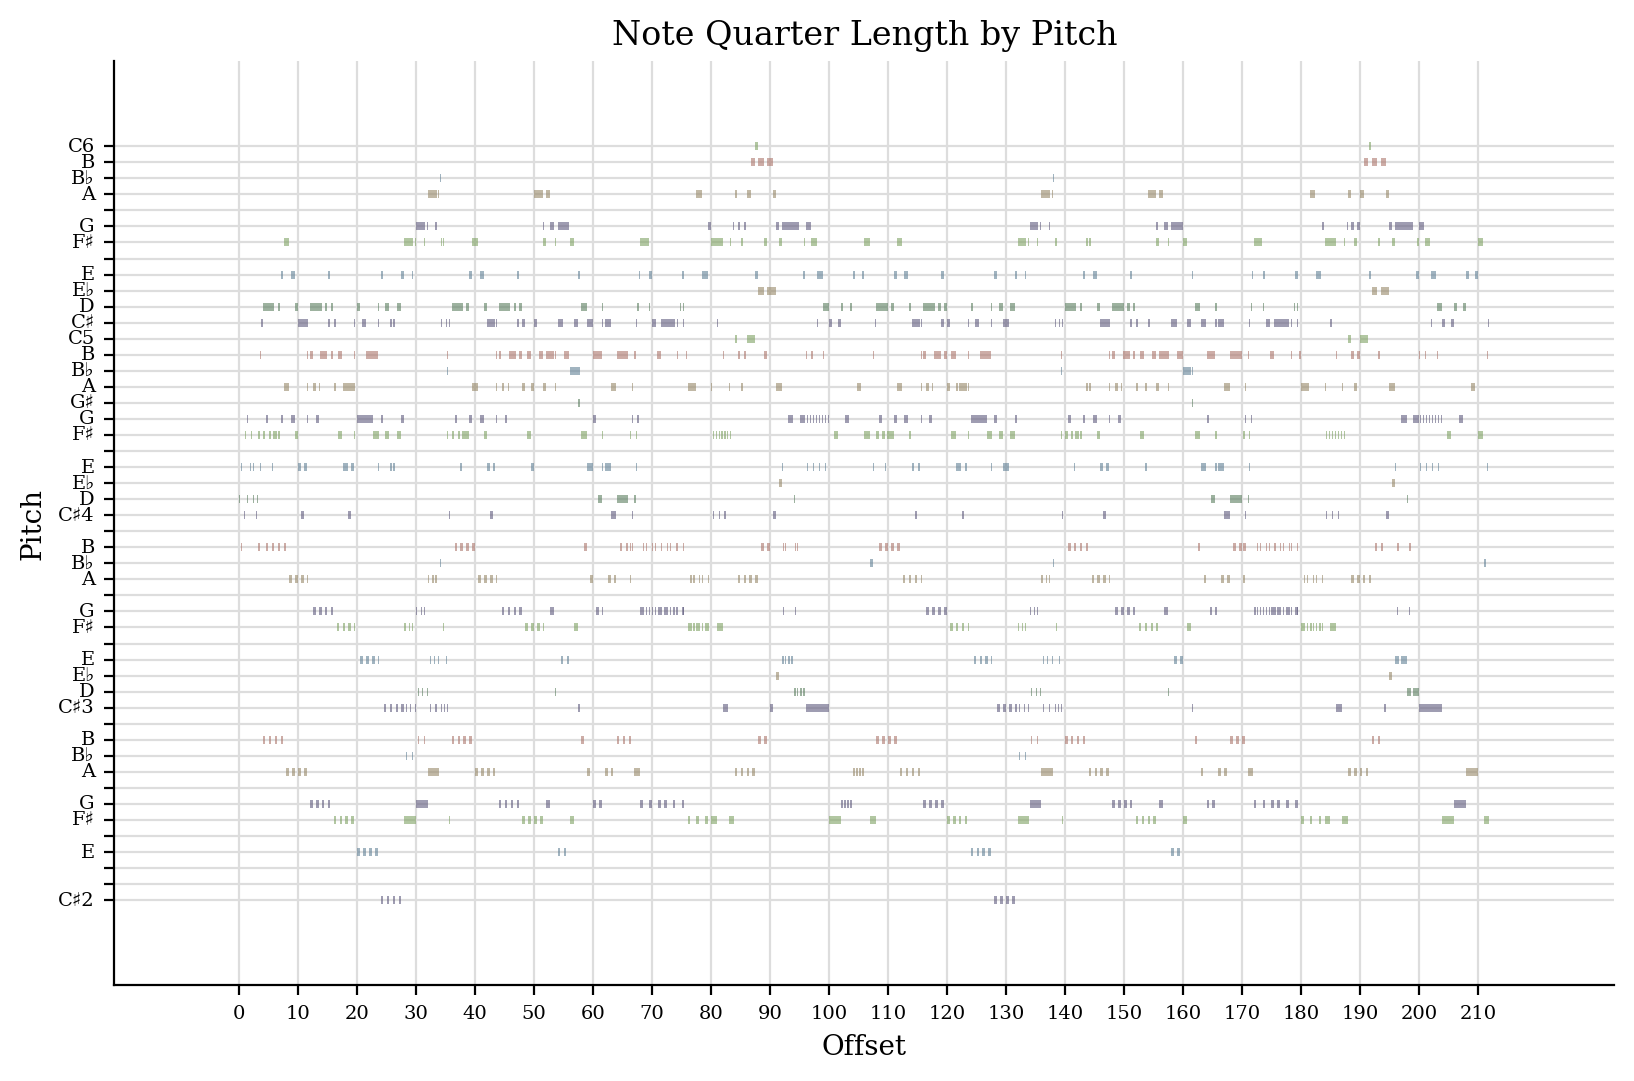

In [34]:
reconstructed_final_fantasy_stream = idx_to_stream_enc(final_fantasy_idx_score, vocab)
reconstructed_final_fantasy_stream.plot()

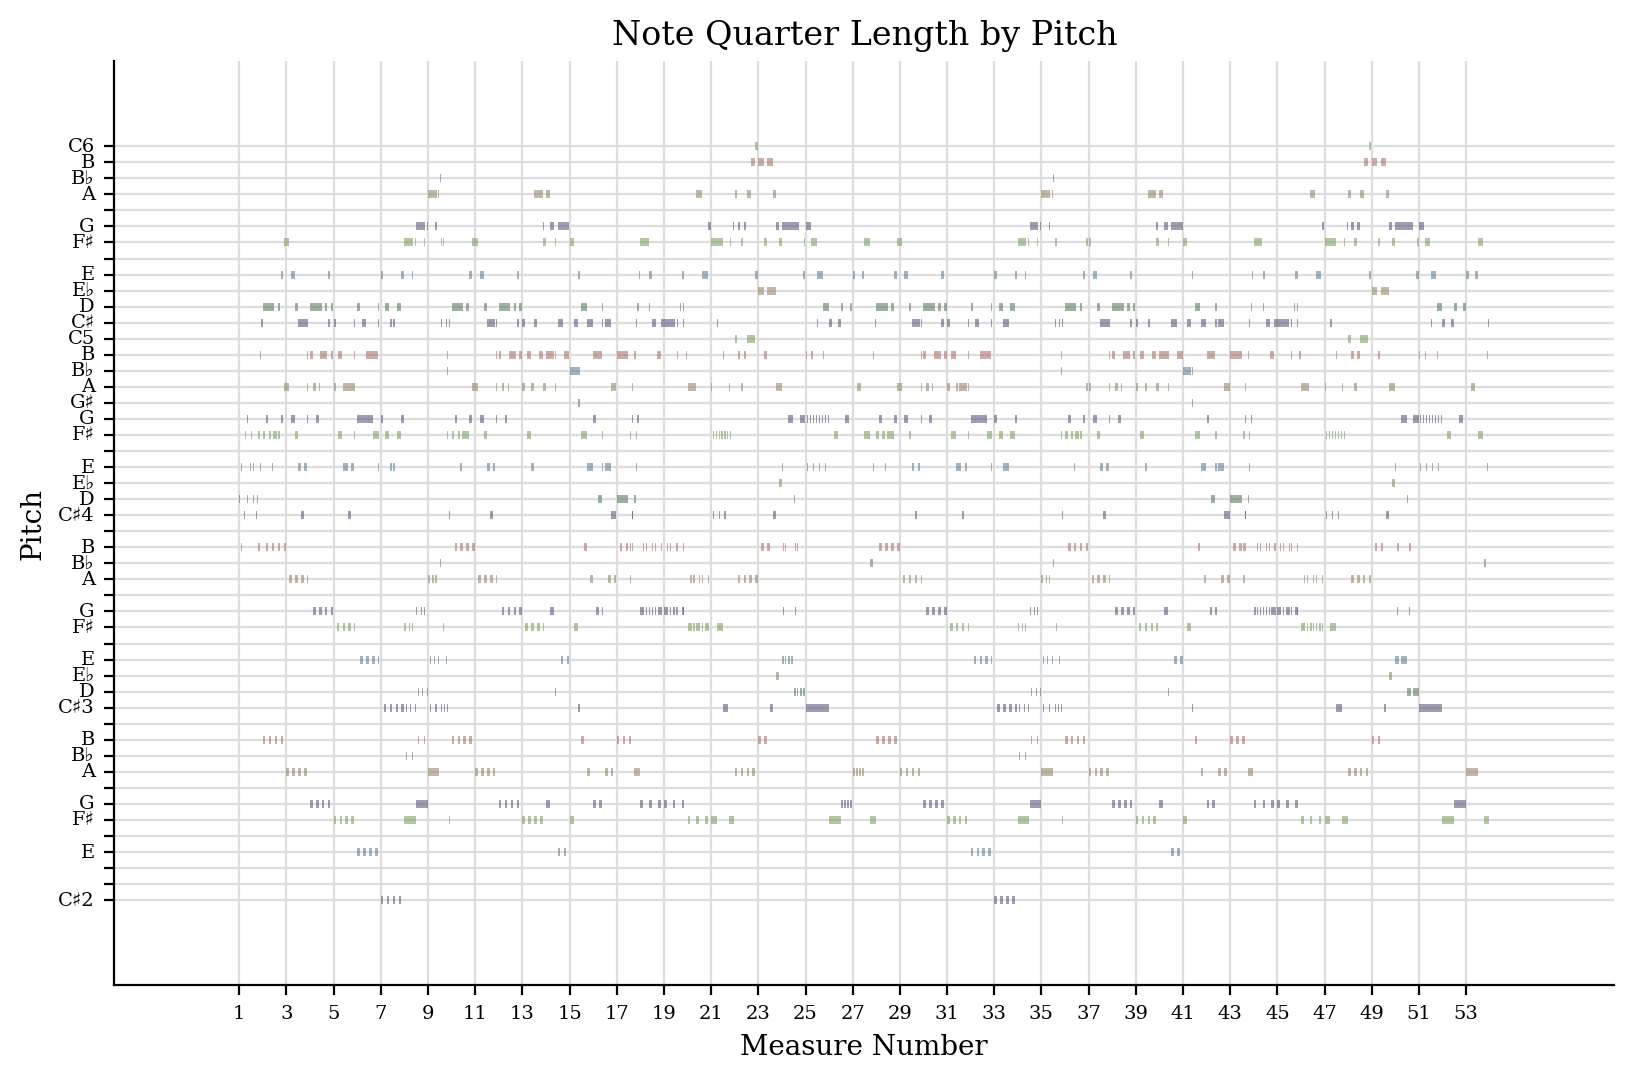

In [35]:
final_fantasy_m21stream.plot()

In [36]:
reconstructed_final_fantasy_stream.show('midi')

In [37]:
final_fantasy_m21stream.show('midi')

Looking and sounding good!

# Bigram MLP

### One Hot Encoding

If we want to feed the sequence integers into a neural net they need to be one hot encoded.

In [38]:
idx_score.shape

(38,)

One hot encoding gives us a value for every possible token at every step, where only the active token is 1 and the rest are zero.

We have 266 tokens in our vocab so 39 timesteps yields a (39, 266) tensor.

In [39]:
import torch.nn.functional as F

token_count = len(vocab.itos)
idx_score_tensor = torch.tensor(idx_score)

one_hot_score = F.one_hot(idx_score_tensor, num_classes=token_count)
one_hot_score.shape

torch.Size([38, 264])

In [40]:
one_hot_score

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]])

Be careful that the dtype is correct. We fed in integers soooo...

In [41]:
one_hot_score.dtype

torch.int64

In [42]:
one_hot_score = one_hot_score.float()
one_hot_score

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [43]:
first_10_idx = idx_score[:10]
vocab.to_tokens(first_10_idx)

'<sos> n72 d2 n52 d16 n48 d16 n45 d16 <sep>'

In [44]:
first_10_idx

array([  0,  75, 133,  55, 147,  51, 147,  48, 147,   2])

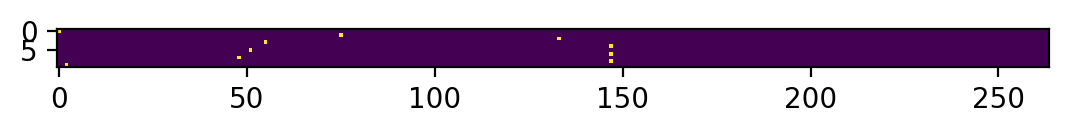

In [45]:
import matplotlib.pyplot as plt

plt.imshow(one_hot_score[:10])

### Simple Bigram NN

Let's see if we can approximate a simple bigram model using Final Fantasy.

We need to create a training set with labels created by offsetting the sequence by one token.

If we use that to train a single linear layer with no activations and one neuron per token, we will approximate a bigram model.

This is because we are simply saying 'given a token, predict the probability of the next' - it's the same function.

The only difference is we are getting there via gradient based learning rather than counting.

In [46]:
xs = torch.tensor(final_fantasy_idx_score[:-1], device=device)
ys = torch.tensor(final_fantasy_idx_score[1:], device=device)

xs.shape, ys.shape

(torch.Size([3161]), torch.Size([3161]))

In [47]:
xs[:10], ys[:10]

(tensor([  0,  65, 132,   2, 132,  67, 132,  62, 132,   2], device='cuda:0'),
 tensor([ 65, 132,   2, 132,  67, 132,  62, 132,   2, 133], device='cuda:0'))

We need to connect every token to every neuron.

266 tokens * 266 neurons = 70756 weights!

In [48]:
W = torch.randn(token_count, token_count, device=device, requires_grad=True) # Weights require gradients for training
W.shape

torch.Size([264, 264])

In [49]:
xenc = F.one_hot(xs, num_classes=token_count).float()
xenc.shape

torch.Size([3161, 264])

Every element in the left matrix first row multiplies by every element in the right matrix first column. These are then summed to make a single number representing the total activation of the first example for the first neuron.

Every element in the left matrix first row multiplies then multiplies by every element in the right matrix *second* column and sums to give the next number, representing the activation of the first example for the second neuron.

Repeat for every column, so we end up with the same number of cols as the right matrix had.

Repeat for every row, so we end up with as many rows as the left matrix had.

(3162, 266) @ (266, 266) = (3162, 266)

i.e. for each of the 3163 examples, we know how much it activated each of the 266 neurons.

In [50]:
logits = xenc @ W # log-counts
logits.shape

torch.Size([3161, 264])

### Outputs

We ultimately want our output neuron values to represent the likelyhood of the next token in the sequence.

Currently they are completely random numbers, both positive and negative.

If treat them as the log "counts" (i.e. logits) then we need to exponentiate them to get the counts.

The `exp` function outputs values between zero and one for inputs below zero, and outputs values above one for inputs above zero, so we know out output will be non-negative.

In [51]:
counts = logits.exp()

Now we need to normalise the logits to get probabilities. We can do this by dividing by the sum of the logits for each timestep. 

This process of exponentiation and normalising is know as the softmax function.

The probablilities for each token now sum to 1.

In [52]:
probs = counts / counts.sum(1, keepdim=True)
probs

tensor([[0.0061, 0.0025, 0.0011,  ..., 0.0040, 0.0017, 0.0099],
        [0.0020, 0.0101, 0.0008,  ..., 0.0043, 0.0027, 0.0007],
        [0.0071, 0.0010, 0.0009,  ..., 0.0020, 0.0006, 0.0015],
        ...,
        [0.0071, 0.0010, 0.0009,  ..., 0.0020, 0.0006, 0.0015],
        [0.0031, 0.0011, 0.0006,  ..., 0.0078, 0.0014, 0.0016],
        [0.0071, 0.0010, 0.0009,  ..., 0.0020, 0.0006, 0.0015]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [53]:
probs.sum(1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

All of these operations are differentiable.

### Loss

So - at this point we can 

- apply our weights
- interpret the output
- compare the output to the known next token (label).

We need a loss function in order to measure how well we did.

This will allow us to adjust nudge the weights in the appropriate direction, and in doing so train the network.

Because we are doing classification, we will use negative-log-likelyhood as our loss function (as opposed to mean squared error in regression).

#### Predictions

We want to pluck out the probabilities that our model assigned to the label values, so we can assess how well it did at predicting the known correct answer.

In [54]:
sample_count = probs.shape[0]
sample_count

3161

In [55]:
likelyhoods = probs[torch.arange(sample_count), ys] # from every row (timestep), pick the yth token probability
likelyhoods

tensor([0.0075, 0.0007, 0.0009,  ..., 0.0003, 0.0008, 0.0010], device='cuda:0',
       grad_fn=<IndexBackward0>)

- Multiply chance of each part of a sequence occuring to get overall likelyhood
- As each is less than 1 (100%), multiplying them makes very small number, which is inconvenient
- Taking the log of the likelyhood makes it -inf -> 0 range (log(1) = 0)
- Also means you add them instead of multiplying
- Invert to get a loss function that goes from zero to inf.
- This is negative log likelyhood.
- Divide by the count of samples to get average negative log likelyhood.

In [56]:
loss = -likelyhoods.log().mean() # negative log likelihood
loss

tensor(6.3691, device='cuda:0', grad_fn=<NegBackward0>)

Now we can back propagate the gradients.

The compute graph has been tracked by PyTorch, so it can work back from our output loss tensor right through to the first (and in out case, only) layer of weights.

In [57]:
W.grad = None # zero the gradients
loss.backward()

In [58]:
W.shape

torch.Size([264, 264])

In [59]:
W.grad

tensor([[1.9147e-06, 7.8448e-07, 3.3507e-07,  ..., 1.2528e-06, 5.4157e-07,
         3.1198e-06],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.9155e-03, 8.6719e-05, 5.0847e-04,  ..., 2.4197e-04, 4.4308e-04,
         6.0655e-05],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')

Now we repeat this process many times, each time moving the weights a small amount in the opposite direction of the loss gradient (i.e. gradient descent).

##### Regularisation

If all the weights were zero, everything would have equal probability.

Therefore, pushing the model weights towards zero smooths the predictions out.

We can acheive this by increasing the loss relative to the sum of squared weights. This is L2 regularisation.

In [60]:
iterations = 100000
learning_rate = 3
lambda_l2 = 0.0001

for i in range(iterations):
    # forward pass
    xenc = F.one_hot(xs, num_classes=token_count).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(sample_count), ys].log().mean() # + lambda_l2 * (W**2).sum() # L2 Regularisation
    print (f'Loss: {loss.item()}')

    # backward pass
    W.grad = None
    loss.backward()

    # update weights
    W.data += -learning_rate * W.grad

Loss: 6.369107723236084
Loss: 6.2818603515625
Loss: 6.194869041442871
Loss: 6.108169078826904
Loss: 6.021803379058838
Loss: 5.935835361480713
Loss: 5.850345134735107
Loss: 5.765443325042725
Loss: 5.6812663078308105
Loss: 5.597992420196533
Loss: 5.515842914581299
Loss: 5.435092926025391
Loss: 5.356069087982178
Loss: 5.279155254364014
Loss: 5.204776763916016
Loss: 5.133380889892578
Loss: 5.06540584564209
Loss: 5.001232624053955
Loss: 4.941140174865723
Loss: 4.8852620124816895
Loss: 4.833568096160889
Loss: 4.785869121551514
Loss: 4.741853713989258
Loss: 4.701131820678711
Loss: 4.663288116455078
Loss: 4.627923965454102
Loss: 4.594682216644287
Loss: 4.563267230987549
Loss: 4.5334391593933105
Loss: 4.505014896392822
Loss: 4.47785758972168
Loss: 4.451865196228027
Loss: 4.426961421966553
Loss: 4.403087139129639
Loss: 4.380192756652832
Loss: 4.358234882354736
Loss: 4.3371686935424805
Loss: 4.316947937011719
Loss: 4.297523498535156
Loss: 4.278844356536865
Loss: 4.260854721069336
Loss: 4.24350118

Without regularisation, 1.799 *should* be approximately what we would have found by explicitly counting the next note probabilities (e.g. a bigram model).

The one hot encoding means that each input only has a single weight, selected by the single active token, that actually affects it.

This is equivalent to selecting the row of the input token to find the probabilities of the output token in the bigram counts table.

### Sampling from the model

> Note - this will be terrible!

If we init a sequence with our 'start of seq` special token (index 0) then we can get the model to generate probabilities for the next note.

We can sample from that distribution to select a note, and repeat to build a performance.

We will terminate when we see the EOS token.


In [61]:
out = [0]
ix = 0
while True:
    x = torch.tensor([ix], device=device)
    xenc = F.one_hot(x, num_classes=token_count).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    ix = torch.multinomial(probs, 1).item()
    out.append(ix)
    if ix == vocab.eos_idx: break

The longer the sequence goes on, the more likely we will get two notes or two durations in a row which will cause errors when we pair them up.

Because of this, with the current algorithm subsequent runs of this workbook may or may not succeed to generate a valid sequence.

> This can of course be fixed both by filtering out invalid data and improving the algorithm, but we are keeping things simple for now.

In [62]:
# Just grabbing first few tokens as the longer the sequence goes on, the more likely we will get two notes or two durations in a row which will cause errors when we pair them up.
gen_idx_score = np.array(out[0:100])
vocab.to_tokens(gen_idx_score)

'<sos> n62 d8 n73 d1 n74 d94 n8 d48 d115 n79 d3 <sep> d4 n64 d2 <sep> d2 n67 d2 n84 d2 n64 d2 n74 d2 <sep> d2 n52 d1 <sep> d2 n57 d1 <sep> d2 n43 d2 n42 d3 n67 d1 n59 d1 <sep> d1 <sep> d1 n76 d1 n55 d2 <sep> d2 <sep> d1 <sep> d2 n79 d1 n59 d2 n69 d1 n66 d1 <sep> d2 n54 d1 <sep> d1 n78 d2 n73 d1 n78 d2 n69 d2 <sep> d2 <sep> d2 n74 d2 <sep> d1 n67 d2 n59 d2 <sep> d2 n59 d1 n59 d2 <sep> d2'

In [63]:
gen_stream_score = idx_to_stream_enc(gen_idx_score, vocab)

IndexError: index 243 is out of bounds for axis 2 with size 128

In [ ]:
gen_stream_score.plot()

In [ ]:
gen_stream_score.show('midi')

Beautiful... ^_^

Unsurprisingly, a single character of context isn't very much to go on.

However, if we were to have 2 characters of context, we would have 266 * 266 = 70756 possibilities and therefore need that many neurons.

This obviously doesn't scale to larger and larger contexts, as it is growing exponentially.

# Summary

We
- Loaded MIDI files from disk using Music
- Converted them to Music21 stream objec
- Converted the stream into a sparse score, where we have a duration value for every pitch at every timeste
- Converted the sparse score into a dense position score. This just records what note starts playing for how long, and the gaps between note
- Converted the position score into a list of integers which represent the index of the token in our vocabulary which consists of note, duration and special token
- One-hot encoded the position score to make it suitable for feeding in to a neural net
- Initialised a weight for each of the 266 tokens
- Split the data into inputs and labels by offsetting the sequence by one step
- Multiplied the imputs by the weights to get random predictions
- Calculated the gradients of the errors
- Nudged the weights in th opposite direction, and repeat
- Because this is algorithm has a weight per token and is learning to predict the next token, without any non-linearities (i.e. the one hot encoded input token is plucking out a single sample of weights) it will quickly approximate an explicitly counted bigram model.
- Taken the output weights, fed in the Start of Sequence token to get it to spit out a prediction, then fed that prediction in to get the next etc etc to build an index score.
- Decoded that score into a stream which we can listen to
- Confirmed that a single token of context is terrible and doesn't scale!

# Next time

- We need to load a bigger training set. Perhaps the next step could be combining all the game music MIDI files into a single stream. It isn't huge, but much bigger than what we already have and would be good practice for even larger sets.

- We need an MLP with embeddings and non-linearities to allow us to expand our context window and detect patterns in the data.
